# Experimentations

## Imports

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.color import convert_colorspace, rgb2gray

from scripts.config import EXAMPLE_IMGS, NOISY_BG_OUTLIERS, HAND_IMGS, PROBLEMATIC_HOUGH_CIRCLES

from scripts.preprocessing import read_image_from_path
from scripts.preprocessing import (scale_hough_circles, get_hough_circles, read_image, apply_hsv_threshold,
                                   adjust_contrast, apply_sobel, apply_hough, apply_closing, apply_opening, apply_operation, apply_black_tophat, apply_white_tophat, apply_erosion, apply_dilation, remove_holes)

from scripts.descriptors import descr_mean, descr_std, descr_mean_center, descr_std_center, descr_img_smoothness

from scripts.descr_preprocessing import extract_circular_region

from scripts.viz import plot_images


## Parameters

In [24]:
seg_5chf_filename = '5CHF_seg.jpg'
seg_1eur_filename = "1EUR_seg.jpg"

image_5chf = io.imread(f'{seg_5chf_filename}')
image_1eur = io.imread(f'{seg_1eur_filename}')

operation_dict = {'opening': apply_opening,
	'sobel': apply_sobel,
	'threshold': apply_hsv_threshold,
	'contrast': adjust_contrast,
	'erosion': apply_erosion,
	'dilation': apply_dilation,
	'blackth': apply_black_tophat,
	'whiteth': apply_white_tophat
	}

operation_list = ['contrast', 'opening', 'threshold', 'sobel']

## Check Hough circles on original image

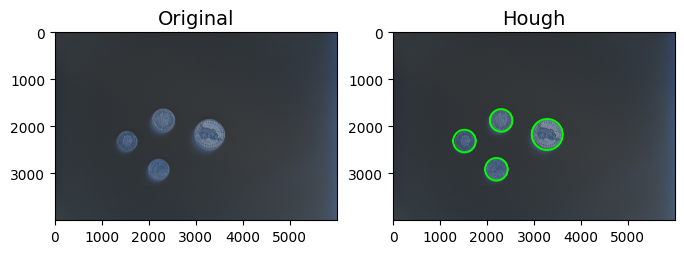

In [34]:
filepath = 'train/L1010279.JPG'

ratio = 10
max_width = 6000
max_height = 4000

# Preprocess rescaled image
img_rescaled = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=True)
output_list = apply_operation(img_rescaled, operation_list, operation_dict)

# Get circles and rescale to original image size
hough_circles = get_hough_circles(output_list[-1], img_rescaled)
hough_circles_rescaled = scale_hough_circles(hough_circles, ratio, 0, 0)

# Plot original image with rescaled circles
img_original = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=False)
img_original_hough = img_original.copy()

for (x,y,r) in hough_circles_rescaled:
	cv2.circle(img_original_hough, (x,y), r, (0,255,0), 40)

plot_images(
	original=img_original,
	hough=img_original_hough
)



## Check on extracted region

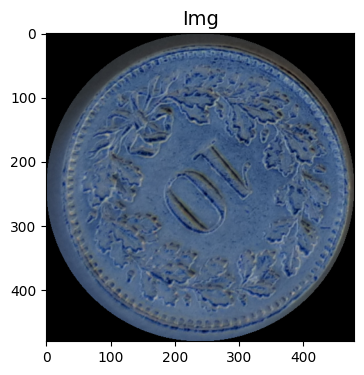

In [35]:
img_original = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=False)

# Get region defined by Hough circle
c = hough_circles_rescaled[2]
xcenter, ycenter, radius = c
margin = 0.0
radius = int(radius * (1 + margin))
img_extract = extract_circular_region(img_original, xcenter, ycenter, radius)

plot_images(
	img=img_extract
)

# Descriptors experimentations

## Mean and std descriptors for several color channels

In [36]:
img_rgb_mean = descr_mean(img_extract)
img_hsv_mean = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
img_yuv_mean = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

In [37]:
img_rgb_std = descr_std(img_extract)
img_hsv_std = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
img_yuv_std = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))


## Laplacian as a measure of image smoothness

In [38]:
img_smoothness = descr_img_smoothness(img_extract)
img_smoothness

0.07329558142701528

## FFT experiments

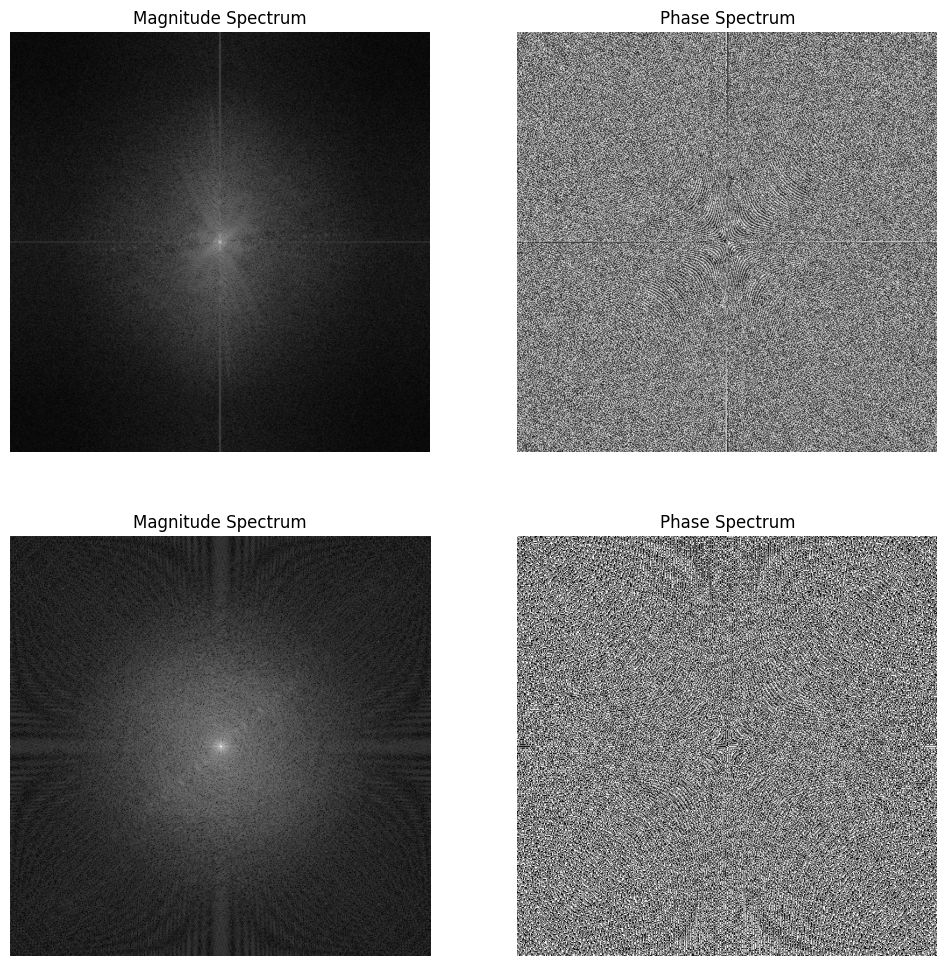

In [39]:
# Compute the 2D FFT
fft_eur = np.fft.fft2(rgb2gray(np.copy(image_1eur)))
fft_eur_shifted = np.fft.fftshift(fft_eur)
mag_eur = np.abs(fft_eur_shifted)
phi_eur = np.angle(fft_eur_shifted)

fft_chf = np.fft.fft2(rgb2gray(np.copy(img_extract)))
fft_chf_shifted = np.fft.fftshift(fft_chf)
mag_chf = np.abs(fft_chf_shifted)
phi_chf = np.angle(fft_chf_shifted)


fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0,0].imshow(np.log(mag_eur + 1), cmap='gray')
axes[0,0].set_title('Magnitude Spectrum')
axes[0,0].axis('off')

axes[0,1].imshow(phi_eur, cmap='gray')
axes[0,1].set_title('Phase Spectrum')
axes[0,1].axis('off')

axes[1,0].imshow(np.log(mag_chf + 1), cmap='gray')
axes[1,0].set_title('Magnitude Spectrum')
axes[1,0].axis('off')

axes[1,1].imshow(phi_chf, cmap='gray')
axes[1,1].set_title('Phase Spectrum')
axes[1,1].axis('off')


plt.show()

## Extract HOG

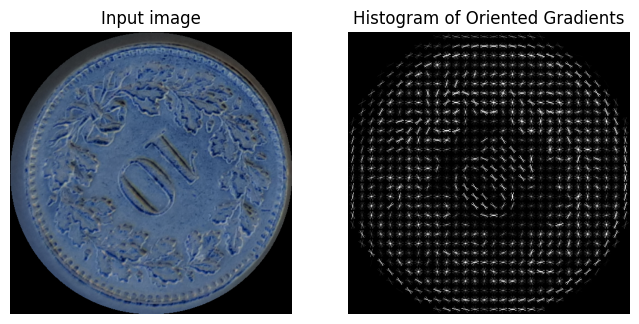

In [40]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = img_extract.copy()

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# Extract descriptors from file

## Imports

In [41]:
from scripts.config import EXAMPLE_IMGS, NOISY_BG_OUTLIERS, HAND_IMGS, PROBLEMATIC_HOUGH_CIRCLES

from scripts.preprocessing import read_image_from_path
from scripts.preprocessing import (scale_hough_circles, get_hough_circles, read_image, apply_hsv_threshold,
                                   adjust_contrast, apply_sobel, apply_hough, apply_closing, apply_opening, apply_operation, apply_black_tophat, apply_white_tophat, apply_erosion, apply_dilation, remove_holes)

from scripts.descr_preprocessing import extract_circular_region

from scripts.viz import plot_images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

## Test descriptors on single file

In [42]:
img_original = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=False)

# Get region defined by Hough circle
c = hough_circles_rescaled[0]
xcenter, ycenter, radius = c
margin = 0.0
radius = int(radius * (1 + margin))
img_extract = extract_circular_region(img_original, xcenter, ycenter, radius)

In [43]:
# Extract descriptors
mean_rgb = descr_mean(img_extract)
mean_hsv = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
mean_yuv = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

std_rgb = descr_std(img_extract)
std_hsv = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
std_yuv = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

smoothness = descr_img_smoothness(img_extract)

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(16, 16),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

In [44]:
# Dict of descriptors
descriptors = {'mean_rgb':mean_rgb,
	'mean_hsv':mean_hsv,
	'mean_yuv':mean_yuv,
	'std_rgb':std_rgb,
	'std_hsv':std_hsv,
	'std_yuv':std_yuv,
	'smoothness':smoothness,
	'hog':hog_image
	}

In [45]:
import pandas as pd

df = pd.DataFrame()
df = df._append(descriptors, ignore_index=True)
df = df._append(descriptors, ignore_index=True)

In [51]:
df['mean_rgb']

0    (66.13915364583333, 80.57018663194444, 99.7598...
1    (66.13915364583333, 80.57018663194444, 99.7598...
Name: mean_rgb, dtype: object

In [48]:
df_filepath = 'dataset_df/L1010279.csv'
df.to_csv(df_filepath)

# File to Hough circles to descriptors

In [21]:
train_dir = 'train'
df_dir = 'dataset_df'

ratio = 10
max_width = 4000
max_height = 6000

# Prepare pandas dataframe to store dataset

for filename in os.listdir(train_dir):

	filepath = os.path.join(train_dir, filename)
	
	df = pd.DataFrame()

	if os.path.isfile(filepath):
		print(f"working on {filepath}")

		# Preprocess rescaled image
		img_rescaled = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=True)
		output_list = apply_operation(img_rescaled, operation_list, operation_dict)

		# Get circles and rescale to original image size
		hough_circles = get_hough_circles(output_list[-1], img_rescaled)
		hough_circles_rescaled = scale_hough_circles(hough_circles, ratio, 0, 0)

		# Prepare original image to extract ROI
		img_original = read_image_from_path(filepath, new_height=400, new_width=600, is_resize=False)

		# Iterate on each Hough circle
		for (x,y,r) in hough_circles_rescaled:
			img_extract = extract_circular_region(img_original, x, y, r)

			# Extract descriptors
			mean_rgb = descr_mean(img_extract)
			mean_hsv = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
			mean_yuv = descr_mean(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

			std_rgb = descr_std(img_extract)
			std_hsv = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='HSV'))
			std_yuv = descr_std(convert_colorspace(img_extract, fromspace='RGB', tospace='YUV'))

			smoothness = descr_img_smoothness(img_extract)

			fd, hog_image = hog(
			img_extract,
			orientations=8,
			pixels_per_cell=(16, 16),
			cells_per_block=(1, 1),
			visualize=True,
			channel_axis=-1,
			)

			descriptors = {'mean_rgb':mean_rgb,
				'mean_hsv':mean_hsv,
				'mean_yuv':mean_yuv,
				'std_rgb':std_rgb,
				'std_hsv':std_hsv,
				'std_yuv':std_yuv,
				'smoothness':smoothness,
				'hog':hog_image
				}

			# Add to dataset
			df = df._append(descriptors, ignore_index=True)
	
	# Save dataset for current file
	df_filename = f"{filename}_DF.csv"
	df.to_csv(path_or_buf=os.path.join(df_dir, df_filename))



working on train\L1010279.JPG
working on train\L1010281.JPG
working on train\L1010283.JPG


KeyboardInterrupt: 

In [ ]:
df